In [30]:
import numpy as np

def calculate_iou(box1, box2):
    # Tính toán Intersection over Union (IoU) giữa hai bounding boxes
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    iou = intersection / float(box1_area + box2_area - intersection)
    return iou

def calculate_ap(precision, recall):
    # Tính toán Average Precision (AP) từ precision và recall
    mrecall = np.concatenate(([0.], recall, [1.]))
    mprecision = np.concatenate(([0.], precision, [0.]))

    for i in range(len(mprecision) - 2, -1, -1):
        mprecision[i] = max(mprecision[i], mprecision[i + 1])

    indices = np.where(mrecall[1:] != mrecall[:-1])[0] + 1
    ap = np.sum((mrecall[indices] - mrecall[indices - 1]) * mprecision[indices])
    return ap

def calculate_map(predictions, true_labels, iou_threshold=0.5):
    num_classes = len(predictions)

    average_precisions = []
    for class_idx in range(num_classes):
        class_predictions = predictions[class_idx]
        class_true_labels = true_labels[class_idx]

        num_detections = len(class_predictions)
        true_positives = np.zeros(num_detections)
        false_positives = np.zeros(num_detections)

        gt_boxes = [label[1:] for label in class_true_labels]
        num_gt_boxes = len(gt_boxes)

        for idx, pred_box in enumerate(class_predictions):
            ious = [calculate_iou(pred_box, gt_box) for gt_box in gt_boxes]

            best_match_idx = np.argmax(ious)
            if ious[best_match_idx] >= iou_threshold:
                if not class_true_labels[best_match_idx][0]:
                    true_positives[idx] = 1
                    class_true_labels[best_match_idx][0] = True
                else:
                    false_positives[idx] = 1
            else:
                false_positives[idx] = 1

        cumulative_true_positives = np.cumsum(true_positives)
        cumulative_false_positives = np.cumsum(false_positives)
        recall = cumulative_true_positives / num_gt_boxes
        precision = cumulative_true_positives / (cumulative_true_positives + cumulative_false_positives)

        average_precision = calculate_ap(precision, recall)
        average_precisions.append(average_precision)

    mean_average_precision = np.mean(average_precisions)
    return mean_average_precision

def read_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            data.append([float(v) for v in values])
    return data

predictions = read_data(r'data\images\test\0000006_00159_d_0000001.txt')
true_labels = read_data(r'runs\detect\exp\labels\0000006_00159_d_0000001.txt')
# Tính toán mAP50
mAP50 = calculate_map(predictions, true_labels)
print("mAP50:", mAP50)


TypeError: 'float' object is not subscriptable

In [1]:
import numpy as np
from collections import Counter

In [4]:
def get_boxes(file_path):
    """
    Đọc các hộp giới hạn từ file theo định dạng YOLOv5
    """
    boxes = []
    with open(file_path, 'r') as f:
        for line in f:
            box = [float(x) for x in line.strip().split()]
            boxes.append(box)
    return boxes

def compute_iou(box1, box2):
    """
    Tính toán Intersection over Union (IoU) giữa hai hộp giới hạn
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    xI1 = max(x1, x2)
    yI1 = max(y1, y2)
    xI2 = min(x1 + w1, x2 + w2)
    yI2 = min(y1 + h1, y2 + h2)
    
    inter_area = max(0, xI2 - xI1) * max(0, yI2 - yI1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area
    
    iou = inter_area / union_area
    return iou

def compute_ap(true_boxes, pred_boxes, iou_threshold=0.1):
    """
    Tính toán Average Precision (AP) cho một lớp đối tượng
    """
    true_positives = []
    false_positives = []
    
    for pred_box in pred_boxes:
        best_iou = max([compute_iou(pred_box, true_box) for true_box in true_boxes])
        if best_iou > iou_threshold:
            true_positives.append(1)
            false_positives.append(0)
        else:
            true_positives.append(0)
            false_positives.append(1)
    
    sorted_indices = np.argsort([-tp for tp in true_positives])
    true_positives = [true_positives[i] for i in sorted_indices]
    false_positives = [false_positives[i] for i in sorted_indices]
    
    tp_sum = np.cumsum(true_positives)
    fp_sum = np.cumsum(false_positives)
    
    precisions = [tp_sum[i] / (tp_sum[i] + fp_sum[i]) for i in range(len(tp_sum))]
    recalls = [tp_sum[i] / len(true_boxes) for i in range(len(tp_sum))]
    
    ap = 0
    for i in range(len(precisions)):
        ap += precisions[i] * (recalls[i] - (recalls[i-1] if i > 0 else 0))
    
    return ap

def compute_map(true_boxes, pred_boxes, iou_threshold=0.1):
    """
    Tính toán Mean Average Precision (mAP) trên tất cả các lớp đối tượng
    """
    true_boxes_per_class = Counter([box[0] for box in true_boxes])
    pred_boxes_per_class = Counter([box[0] for box in pred_boxes])
    
    aps = []
    for class_id in set(true_boxes_per_class.keys()).union(pred_boxes_per_class.keys()):
        true_boxes_class = [box[1:] for box in true_boxes if box[0] == class_id]
        pred_boxes_class = [box[1:] for box in pred_boxes if box[0] == class_id]
        
        ap = compute_ap(true_boxes_class, pred_boxes_class, iou_threshold)
        aps.append(ap)
    
    map = sum(aps) / len(aps)
    return map

In [5]:
# Đọc dữ liệu từ các file
true_boxes = get_boxes(r'data\images\test\0000006_00159_d_0000001.txt')
pred_boxes = get_boxes(r'runs\detect\exp\labels\0000006_00159_d_0000001.txt')
# pred_boxes = get_boxes(r'data\images\test\0000006_00159_d_0000001.txt')
# Tính toán mAP
map = compute_map(true_boxes, pred_boxes)
print(f'Mean Average Precision (mAP): {map:.4f}')

Mean Average Precision (mAP): 0.1784


In [13]:
import numpy as np

def parse_txt_labels(file_path):
  """Parses a text file containing bounding box labels.

  Args:
    file_path: Path to the text file.

  Returns:
    labels (list): List of labels (class_id, xmin, ymin, xmax, ymax).
  """

  labels = []
  with open(file_path, 'r') as f:  # Directly use file_path
    for line in f:
      label_data = line.strip().split(' ')
      labels.append([float(data) for data in label_data])
  return labels

def compute_iou(gt_box, pred_box):
  """Calculates IoU between two bounding boxes.

  Args:
    gt_box: Ground truth bounding box (xmin, ymin, xmax, ymax).
    pred_box: Predicted bounding box (xmin, ymin, xmax, ymax).

  Returns:
    IoU (float): Intersection over Union between the boxes.
  """
  # Get the coordinates of bounding boxes
  x_min1, y_min1, x_max1, y_max1 = gt_box
  x_min2, y_min2, x_max2, y_max2 = pred_box

  # Calculate the area of intersection and union
  intersection_area = max(0, min(x_max1, x_max2) - max(x_min1, x_min2)) * \
                     max(0, min(y_max1, y_max2) - max(y_min1, y_min2))
  union_area = (x_max1 - x_min1) * (y_max1 - y_min1) + (x_max2 - x_min2) * (y_max2 - y_min2) - intersection_area

  # Calculate IoU
  iou = intersection_area / union_area
  return iou

def compute_ap(gt_boxes, pred_boxes, confidence_scores):
  """Calculates Average Precision (AP) for a single class.

  Args:
    gt_boxes: List of ground truth bounding boxes (class_id, xmin, ymin, xmax, ymax).
    pred_boxes: List of predicted bounding boxes (xmin, ymin, xmax, ymax).
    confidence_scores: List of confidence scores for the predictions.

  Returns:
    AP (float): Average Precision for the class.
  """
  # Calculate precision-recall curve
  precision = np.zeros(len(pred_boxes))
  recall = np.zeros(len(pred_boxes))
  positive_count = len(gt_boxes)  # Assuming all ground truth boxes are positive

  for i in range(len(pred_boxes)):
    # Check if predicted box matches any ground truth box
    matched = False
    for j in range(len(gt_boxes)):
      if compute_iou(pred_boxes[i], gt_boxes[j][:4]) >= 0.5:
        matched = True
        gt_boxes[j][4] = 0  # Mark ground truth box as used
        break

    # Update precision and recall
    precision[i] = (i + 1) / (positive_count + np.sum(precision[:i]))
    recall[i] = 1 - np.sum(gt_boxes[:, 4]) / positive_count

  # Calculate area under Precision-Recall curve (average precision)
  ap = np.sum(precision * np.diff(recall))
  return ap

def compute_mAP50(ground_truth_path, predicted_path):
  """Calculates mean Average Precision (mAP) at IoU threshold of 0.5.

  Args:
    ground_truth_path: Path to the ground truth label text file.
    predicted_path: Path to the predicted label text file.

  Returns:
    mAP50 (float): mean Average Precision at IoU threshold of 0.5.
  """

  # Load labels from files
  ground_truth_labels = parse_txt_labels(ground_truth_path)
  predicted_labels = parse_txt_labels(predicted_path)

  # Group labels by class
  class_labels = {}
  for label in ground_truth_labels:
    class_id = int(label[0])
    if class_id not in class_labels:
      class_labels[class_id] = []
    class_labels[class_id].append(label[1:])

  # Calculate AP for each class and compute mAP
  mAP = 0
  for class_id, gt_boxes in class_labels.items():
    gt_boxes = np.array(gt_boxes)

    # Filter predictions for the current class
    class_predictions = [pred for pred in predicted_labels if int(pred[0]) == class_id]
    pred_boxes = np.array([pred[1:] for pred in class_predictions])
    confidence_scores = np.array([float(pred[0]) for pred in class_predictions])

    # Compute AP for the class
    ap = compute_ap(gt_boxes, pred_boxes, confidence_scores)
    mAP += ap

  # Calculate mAP as average of class APs
  mAP = mAP / len(class_labels)
  return mAP

# Example usage (replace with your actual data loading logic)
# ground_truth_labels = [...]  # Load ground truth labels from file
# predicted_labels = [...]  # Load predicted labels from file
true_boxes = r'data\images\test\0000006_00159_d_0000001.txt'
pred_boxes = r'runs\detect\exp\labels\0000006_00159_d_0000001.txt'
#
mAP50 = compute_mAP50(true_boxes, pred_boxes)
print("mAP@0.5:", mAP50)

IndexError: index 4 is out of bounds for axis 1 with size 4

In [23]:
import numpy as np

def get_boxes(file_path):
    """
    Đọc các hộp giới hạn từ file theo định dạng YOLOv5
    """
    boxes = []
    with open(file_path, 'r') as f:
        for line in f:
            box = [float(x) for x in line.strip().split()]
            boxes.append(box)
    return boxes

def compute_iou(box1, box2):
    """
    Tính toán Intersection over Union (IoU) giữa hai hộp giới hạn
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    xI1 = max(x1, x2)
    yI1 = max(y1, y2)
    xI2 = min(x1 + w1, x2 + w2)
    yI2 = min(y1 + h1, y2 + h2)
    
    inter_area = max(0, xI2 - xI1) * max(0, yI2 - yI1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area
    
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

def compute_ap(true_boxes, pred_boxes, iou_threshold=0.5):
    """
    Tính toán Average Precision (AP) cho một lớp đối tượng
    """
    true_positives = []
    false_positives = []
    
    for pred_box in pred_boxes:
        best_iou = max([compute_iou(pred_box, true_box) for true_box in true_boxes])
        if best_iou > iou_threshold:
            true_positives.append(1)
            false_positives.append(0)
        else:
            true_positives.append(0)
            false_positives.append(1)
    
    sorted_indices = np.argsort([-tp for tp in true_positives])
    true_positives = [true_positives[i] for i in sorted_indices]
    false_positives = [false_positives[i] for i in sorted_indices]
    
    tp_sum = np.cumsum(true_positives)
    fp_sum = np.cumsum(false_positives)
    
    precisions = [tp_sum[i] / (tp_sum[i] + fp_sum[i]) for i in range(len(tp_sum))]
    recalls = [tp_sum[i] / len(true_boxes) for i in range(len(tp_sum))]
    
    ap = 0
    for i in range(len(precisions)):
        ap += precisions[i] * (recalls[i] - (recalls[i-1] if i > 0 else 0))
    
    return ap

def evaluate_image(true_labels_path, pred_labels_path):
    """
    Đánh giá độ chính xác cho một bức ảnh duy nhất
    """
    true_boxes = get_boxes(true_labels_path)
    pred_boxes = get_boxes(pred_labels_path)
    
    true_boxes_per_class = {box[0]: [box[1:]] for box in true_boxes}
    pred_boxes_per_class = {box[0]: [box[1:]] for box in pred_boxes}
    
    aps = []
    for class_id in set(true_boxes_per_class.keys()).union(pred_boxes_per_class.keys()):
        true_boxes_class = true_boxes_per_class.get(class_id, [])
        pred_boxes_class = pred_boxes_per_class.get(class_id, [])
        
        ap_05 = compute_ap(true_boxes_class, pred_boxes_class, iou_threshold=0.5)
        aps.append(ap_05)
    
    map_05 = sum(aps) / len(aps) 
    
    iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    aps_all = []
    for iou_threshold in iou_thresholds:
        aps = []
        for class_id in set(true_boxes_per_class.keys()).union(pred_boxes_per_class.keys()):
            true_boxes_class = true_boxes_per_class.get(class_id, [])
            pred_boxes_class = pred_boxes_per_class.get(class_id, [])
            
            ap = compute_ap(true_boxes_class, pred_boxes_class, iou_threshold=iou_threshold)
            aps.append(ap)
        aps_all.append(aps)
    
    map_05_095 = np.mean([np.mean(aps) for aps in aps_all])
    
    print(f'mAP@0.5: {map_05:.4f}')
    print(f'mAP@0.5:0.95: {map_05_095:.4f}')
    
# true_boxes = get_boxes(r'data\images\test\0000006_00159_d_0000001.txt')
# pred_boxes = get_boxes(r'runs\detect\exp\labels\0000006_00159_d_0000001.txt')
# Sử dụng hàm để đánh giá độ chính xác cho một bức ảnh
evaluate_image(r'data\images\test\0000006_00159_d_0000001.txt', r'runs\detect\exp\labels\0000006_00159_d_0000001.txt')

mAP@0.5: 0.0000
mAP@0.5:0.95: 0.0000


In [2]:
import numpy as np


def load_labels(txt_file):
    with open(txt_file, 'r') as file:
        lines = file.readlines()
    labels = []
    for line in lines:
        data = line.strip().split(' ')
        class_label = int(data[0])  # Class label
        x_center, y_center, width, height = map(float, data[1:])  # Bounding box coordinates
        labels.append({'class': class_label, 'x_center': x_center, 'y_center': y_center, 'width': width, 'height': height})
    return labels


def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1['x_center'], box1['y_center'], box1['width'], box1['height']
    x2, y2, w2, h2 = box2['x_center'], box2['y_center'], box2['width'], box2['height']
    xmin1, xmax1 = x1 - w1/2, x1 + w1/2
    ymin1, ymax1 = y1 - h1/2, y1 + h1/2
    xmin2, xmax2 = x2 - w2/2, x2 + w2/2
    ymin2, ymax2 = y2 - h2/2, y2 + h2/2
    inter_xmin = max(xmin1, xmin2)
    inter_xmax = min(xmax1, xmax2)
    inter_ymin = max(ymin1, ymin2)
    inter_ymax = min(ymax1, ymax2)
    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)
    box1_area = w1 * h1
    box2_area = w2 * h2
    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

def evaluate_mAP(true_labels, pred_labels, iou_threshold=0.6):
    num_true_positives = 0
    num_predicted = 0
    for true_label in true_labels:
        best_iou = 0
        for pred_label in pred_labels:
            iou = calculate_iou(true_label, pred_label)
            if iou > best_iou:
                best_iou = iou
        if best_iou >= iou_threshold:
            num_true_positives += 1
    precision = num_true_positives / len(pred_labels)
    recall = num_true_positives / len(true_labels)
    return precision, recall

# File paths, 
true_label_file = r'data\images\test\0000006_00159_d_0000001.txt'  # File containing true labels in TXT format
pred_label_file = r'runs\detect\exp2\labels\0000006_00159_d_0000001.txt'  # File containing predicted labels in TXT format

# Load labels
true_labels = load_labels(true_label_file)
pred_labels = load_labels(pred_label_file)

# Evaluate mAP
precision, recall = evaluate_mAP(true_labels, pred_labels)
print("Precision:", precision)
print("Recall:", recall)


Precision: 0.75
Recall: 0.4225352112676056


In [5]:
def calculate_ap(precisions, recalls):
    # Add two additional points to precision-recall curve
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Compute area under precision-recall curve
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = max(precisions[i], precisions[i + 1])

    # Find indices where recall changes
    change_indices = np.where(recalls[1:] != recalls[:-1])[0] + 1

    # Summarize area under precision-recall curve
    ap = np.sum((recalls[change_indices] - recalls[change_indices - 1]) * precisions[change_indices])
    return ap

def calculate_map(precision, recall, iou_thresholds=[0.5]):
    aps = []
    for iou_threshold in iou_thresholds:
        ap = calculate_ap(precision, recall)
        aps.append(ap)
    return np.mean(aps)

# Calculate mAP50 and mAP50-95
mAP50 = calculate_map(precision, recall, iou_thresholds=[0.5])
mAP50_95 = calculate_map(precision, recall, iou_thresholds=np.arange(0.5, 1.0, 0.05))

print("mAP50:", mAP50)
print("mAP50-95:", mAP50_95)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)

In [4]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json

def txt_to_coco_format(txt_file):
    coco_format_data = {"images": [], "annotations": []}
    with open(txt_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            line = line.strip().split(' ')
            image_id = int(line[0])  # Assuming the first element is image ID
            x, y, width, height = map(float, line[1:5])  # Assuming next 4 elements are bbox coordinates
            category_id = int(line[5])  # Assuming the last element is category ID
            # Create annotation
            annotation = {
                "image_id": image_id,
                "bbox": [x, y, width, height],
                "category_id": category_id
            }
            coco_format_data["annotations"].append(annotation)
    return coco_format_data

def evaluate_mAP(true_coco, pred_coco):
    # Create COCO evaluation object
    coco_eval = COCOeval(true_coco, pred_coco, 'bbox')
    # Run evaluation
    coco_eval.evaluate()
    coco_eval.accumulate()
    # Print evaluation summary
    coco_eval.summarize()

# File paths
# true_label_txt_file = 'true_labels.txt'  # File containing true labels in TXT format
# pred_label_txt_file = 'predicted_labels.txt'  # File containing predicted labels in TXT format

true_label_txt_file = r'data\images\test\0000006_00159_d_0000001.txt'  # File containing true labels in TXT format
pred_label_txt_file = r'runs\detect\exp2\labels\0000006_00159_d_0000001.txt'  # File containing predicted labels in TXT format

# Convert TXT to COCO format
true_coco_data = txt_to_coco_format(true_label_txt_file)
pred_coco_data = txt_to_coco_format(pred_label_txt_file)

# Create COCO instances
true_coco = COCO()
true_coco.dataset = true_coco_data
true_coco.createIndex()

pred_coco = true_coco.loadRes(pred_coco_data)

# Evaluate mAP
evaluate_mAP(true_coco, pred_coco)


IndexError: list index out of range

In [2]:
from sklearn.metrics import confusion_matrix
import numpy as np

def read_labels(file_path):
    with open(file_path, 'r') as file:
        labels = file.readlines()
    return [label.strip() for label in labels]

def compute_confusion_matrix(true_labels, predicted_labels, classes):
    true_indices = [classes.index(label) for label in true_labels]
    predicted_indices = [classes.index(label) for label in predicted_labels]
    num_classes = len(classes)
    return confusion_matrix(true_indices, predicted_indices, labels=list(range(num_classes)))

# true_label_file = r'data\images\test\0000006_00159_d_0000001.txt'  # File containing true labels in TXT format
# pred_label_file = r'runs\detect\exp2\labels\0000006_00159_d_0000001.txt'  # File containing predicted labels in TXT format

# Đọc true labels và predicted labels từ file
true_labels = read_labels(r'data\images\test\0000006_00159_d_0000001.txt')
predicted_labels = read_labels(r'runs\detect\exp2\labels\0000006_00159_d_0000001.txt')

# Xác định các lớp có thể có
all_labels = list(set(true_labels + predicted_labels))
all_labels.sort()

# Tính toán confusion matrix
conf_matrix = compute_confusion_matrix(true_labels, predicted_labels, all_labels)


# Hiển thị confusion matrix
print("Confusion Matrix:")
print(np.array(conf_matrix))

ValueError: Found input variables with inconsistent numbers of samples: [71, 40]

In [15]:
import numpy as np
import matplotlib.pyplot as plt
def compute_iou(box1, box2):
    """
    Compute the Intersection over Union (IoU) of two bounding boxes.
    
    Args:
        box1 (list): [x1, y1, x2, y2], where (x1, y1) and (x2, y2) are the coordinates of the top-left and bottom-right corners of the bounding box.
        box2 (list): [x1, y1, x2, y2], where (x1, y1) and (x2, y2) are the coordinates of the top-left and bottom-right corners of the bounding box.
        
    Returns:
        float: IoU value between the two bounding boxes.
    """
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    
    # Calculate the coordinates of the intersection rectangle
    x_intersection1 = max(x1, x3)
    y_intersection1 = max(y1, y3)
    x_intersection2 = min(x2, x4)
    y_intersection2 = min(y2, y4)
    
    # Compute the area of intersection rectangle
    intersection_area = max(0, x_intersection2 - x_intersection1 + 1) * max(0, y_intersection2 - y_intersection1 + 1)
    
    # Compute the area of both bounding boxes
    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x4 - x3 + 1) * (y4 - y3 + 1)
    
    # Compute the IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    
    return iou

def check_true_positive(true_box, pred_box, iou_threshold):
    """
    Check if a predicted bounding box is a true positive.
    
    Args:
        true_box (list): Ground truth bounding box [x1, y1, x2, y2].
        pred_box (list): Predicted bounding box [x1, y1, x2, y2].
        iou_threshold (float): IoU threshold to consider a prediction as true positive.
        
    Returns:
        bool: True if the prediction is a true positive, False otherwise.
    """
    iou = compute_iou(true_box, pred_box)
    if iou >= iou_threshold:
        return True
    else:
        return False

def compute_confusion_matrix(true_labels_file, predicted_labels_file, label_names, iou_threshold=0.5):
    true_labels = load_labels(true_labels_file)
    predicted_labels = load_labels(predicted_labels_file)
    num_classes = len(label_names)
    
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    for true_label, pred_label in zip(true_labels, predicted_labels):
        true_class, true_box = true_label
        pred_class, pred_box = pred_label
        
        is_true_positive = check_true_positive(true_box, pred_box, iou_threshold)
        
        if is_true_positive:
            confusion_matrix[true_class, pred_class] += 1
        else:
            confusion_matrix[true_class, :] += 1
            confusion_matrix[:, pred_class] += 1
            confusion_matrix[true_class, pred_class] -= 1
    
    # Normalize the confusion matrix
    row_sums = np.sum(confusion_matrix, axis=1)
    row_sums = np.where(row_sums == 0, 1, row_sums)  # Avoid division by zero
    normalized_confusion_matrix = confusion_matrix / row_sums[:, np.newaxis]
    
    return normalized_confusion_matrix, label_names

def load_labels(labels_file):
    """
    Đọc nhãn từ file.
    
    Args:
        labels_file (str): Đường dẫn đến file nhãn.
        
    Returns:
        list: Danh sách các nhãn đối tượng.
    """
    labels = []
    with open(labels_file, 'r') as f:
        for line in f:
            label_parts = line.strip().split()
            class_id = int(label_parts[0])
            box = [float(x) for x in label_parts[1:]]
            labels.append((class_id, box))
    return labels

def plot_confusion_matrix(confusion_matrix, label_names):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(confusion_matrix, cmap='Blues')
    ax.set_xticks(np.arange(len(label_names)))
    ax.set_yticks(np.arange(len(label_names)))
    ax.set_xticklabels(label_names, rotation=45)
    ax.set_yticklabels(label_names)
    
    # Add values to the heatmap
    for i in range(len(label_names)):
        for j in range(len(label_names)):
            value = confusion_matrix[i, j]
            text = ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="white" if value > 0.5 else "black")
    
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()

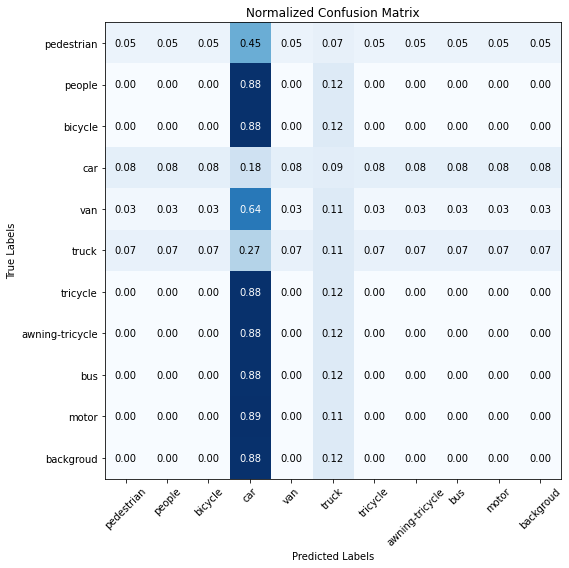

In [18]:
true_labels_file = r'data\images\test\0000006_00159_d_0000001.txt'
# predicted_labels_file = r'data\images\test\0000006_00159_d_0000001.txt'
predicted_labels_file = r'runs\detect\exp2\labels\0000006_00159_d_0000001.txt'
label_names = ['pedestrian','people','bicycle','car','van','truck','tricycle','awning-tricycle','bus','motor','backgroud']
iou_threshold = 0.5

normalized_confusion_matrix, label_names = compute_confusion_matrix(true_labels_file, predicted_labels_file, label_names, iou_threshold)
plot_confusion_matrix(normalized_confusion_matrix, label_names)

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Đọc file nhãn thực tế và dự đoán
# true_labels = np.loadtxt('true_labels.txt')
# pred_labels = np.loadtxt('pred_labels.txt')
true_labels_file = r'data\images\test\0000006_00159_d_0000001.txt'
# predicted_labels_file = r'data\images\test\0000006_00159_d_0000001.txt'
predicted_labels_file = r'runs\detect\exp2\labels\0000006_00159_d_0000001.txt'

# Tính confusion matrix
cm = confusion_matrix(true_labels_file, predicted_labels_file)

# Tạo heatmap từ confusion matrix
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(df_cm, annot=True, fmt='d', cmap='YlGnBu')
heatmap.set_xlabel('Predicted Labels', fontsize=14)
heatmap.set_ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=18)

# Chuẩn hóa heatmap từ 0 đến 1
heatmap.collections[0].colorbar.set_ticks(np.linspace(0, cm.max(), 11))
heatmap.collections[0].colorbar.set_ticklabels(np.linspace(0, 1, 11))

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [44, 51]

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Danh sách các nhãn
label_names = ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'background']

# Đọc file nhãn thực tế và dự đoán
true_labels = np.loadtxt(r'data\images\test\0000006_00159_d_0000001.txt')
pred_labels = np.loadtxt(r'runs\detect\exp2\labels\0000006_00159_d_0000001.txt')

# Tính confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=range(len(label_names)))

# Tạo heatmap từ confusion matrix
df_cm = pd.DataFrame(cm, index=label_names, columns=label_names)
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(df_cm, annot=True, fmt='d', cmap='YlGnBu')
heatmap.set_xlabel('Predicted Labels', fontsize=14)
heatmap.set_ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=18)

# Chuẩn hóa heatmap từ 0 đến 1
heatmap.collections[0].colorbar.set_ticks(np.linspace(0, cm.max(), 11))
heatmap.collections[0].colorbar.set_ticklabels(np.linspace(0, 1, 11))

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [71, 40]

In [20]:


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools

# Các nhãn của bạn
label_names = ['pedestrian','people','bicycle','car','van','truck','tricycle','awning-tricycle','bus','motor','background']

# Hàm đọc file label và predict
def read_labels(file_path):
    with open(file_path, 'r') as file:
        labels = file.readlines()
    return [label.strip() for label in labels]

# Đọc label thực tế và label dự đoán
true_labels = read_labels(r'data\images\test\0000006_00159_d_0000001.txt')
predicted_labels = read_labels(r'runs\detect\exp2\labels\0000006_00159_d_0000001.txt')

# Tạo confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=label_names)

# Chuẩn hóa confusion matrix để tạo heatmap
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [71, 40]

In [28]:
from sklearn.metrics import confusion_matrix, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

# Read true labels from file
# def read_true_labels(file_path):
#     # Assuming each line in the file contains a true label
#     with open(file_path, 'r') as file:
#         true_labels = [float(line.strip()) for line in file]
#     return true_labels
def read_labels(file_path):
    with open(file_path, 'r') as file:
        labels = file.readlines()
    return [label.strip() for label in labels]

# Generate predicted labels (for demonstration purpose, you would replace this with your actual predictions)
def generate_predicted_labels(true_labels):
    # Assuming a random prediction where predicted label is true label + 1
    predicted_labels = [label + 1 for label in true_labels]
    return predicted_labels

# Calculate mAP score
def calculate_mAP(true_labels, predicted_labels):
    mAP = average_precision_score(true_labels, predicted_labels)
    return mAP

# Generate confusion matrix
def generate_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    return cm

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Example usage
# true_labels = read_true_labels(r'data\images\test\0000006_00159_d_0000001.txt')
# predicted_labels = read_true_labels(r'runs\detect\exp2\labels\0000006_00159_d_0000001.txt')
true_labels = read_labels(r'data\images\test\0000006_00159_d_0000001.txt')
predicted_labels = read_labels(r'runs\detect\exp2\labels\0000006_00159_d_0000001.txt')
mAP = calculate_mAP(true_labels, predicted_labels)
print("mAP score:", mAP)

conf_matrix = generate_confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
classes = np.unique(true_labels)
plot_confusion_matrix(conf_matrix, classes)


ValueError: multiclass format is not supported

In [7]:
def get_boxes(file_path):
    """
    Đọc các hộp giới hạn từ file theo định dạng YOLOv5
    """
    boxes = []
    with open(file_path, 'r') as f:
        for line in f:
            box = [float(x) for x in line.strip().split()]
            boxes.append(box)
    return boxes

def compute_iou(box1, box2):
    """
    Tính toán Intersection over Union (IoU) giữa hai hộp giới hạn
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    xI1 = max(x1, x2)
    yI1 = max(y1, y2)
    xI2 = min(x1 + w1, x2 + w2)
    yI2 = min(y1 + h1, y2 + h2)
    
    inter_area = max(0, xI2 - xI1) * max(0, yI2 - yI1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area
    
    iou = inter_area / union_area
    return iou

def compute_ap(true_boxes, pred_boxes, iou_threshold=0.6):
    """
    Tính toán Average Precision (AP) cho một lớp đối tượng
    """
    true_positives = []
    false_positives = []
    
    for pred_box in pred_boxes:
        best_iou = max([compute_iou(pred_box, true_box) for true_box in true_boxes])
        if best_iou > iou_threshold:
            true_positives.append(1)
            false_positives.append(0)
        else:
            true_positives.append(0)
            false_positives.append(1)
    
    sorted_indices = np.argsort([-tp for tp in true_positives])
    true_positives = [true_positives[i] for i in sorted_indices]
    false_positives = [false_positives[i] for i in sorted_indices]
    
    tp_sum = np.cumsum(true_positives)
    fp_sum = np.cumsum(false_positives)
    
    precisions = [tp_sum[i] / (tp_sum[i] + fp_sum[i]) for i in range(len(tp_sum))]
    recalls = [tp_sum[i] / len(true_boxes) for i in range(len(tp_sum))]
    
    ap = 0
    for i in range(len(precisions)):
        ap += precisions[i] * (recalls[i] - (recalls[i-1] if i > 0 else 0))
    
    return ap, precisions, recalls

def compute_map(true_boxes, pred_boxes, iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]):
    """
    Tính toán Mean Average Precision (mAP) trên tất cả các lớp đối tượng
    """
    true_boxes_per_class = Counter([box[0] for box in true_boxes])
    pred_boxes_per_class = Counter([box[0] for box in pred_boxes])
    
    all_aps = []
    all_precisions = []
    all_recalls = []
    
    for class_id in set(true_boxes_per_class.keys()).union(pred_boxes_per_class.keys()):
        true_boxes_class = [box[1:] for box in true_boxes if box[0] == class_id]
        pred_boxes_class = [box[1:] for box in pred_boxes if box[0] == class_id]
        
        aps = []
        precisions = []
        recalls = []
        for iou_threshold in iou_thresholds:
            ap, precision, recall = compute_ap(true_boxes_class, pred_boxes_class, iou_threshold)
            aps.append(ap)
            precisions.append(precision)
            recalls.append(recall)
        
        all_aps.append(aps)
        all_precisions.append(precisions)
        all_recalls.append(recalls)
        
        print(f'Class {class_id}:')
        print(f'  Precision: {[round(p, 4) for p in precisions[0]]}')
        print(f'  Recall: {[round(r, 4) for r in recalls[0]]}')
        print(f'  AP@0.5: {aps[0]:.4f}')
        print(f'  AP@0.5:0.95 (averaged over different IoU thresholds): {np.mean(aps):.4f}')
    
    mean_precisions = [np.mean([prec[i] for prec in all_precisions]) for i in range(len(all_precisions[0][0]))]
    mean_recalls = [np.mean([rec[i] for rec in all_recalls]) for i in range(len(all_recalls[0][0]))]
    mean_aps = [np.mean([ap[i] for ap in all_aps]) for i in range(len(all_aps[0]))]
    
    print(f'\nOverall:')
    print(f'  Precision: {[round(p, 4) for p in mean_precisions]}')
    print(f'  Recall: {[round(r, 4) for r in mean_recalls]}')
    print(f'  mAP@0.5: {mean_aps[0]:.4f}')
    print(f'  mAP@0.5:0.95 (averaged over different IoU thresholds): {np.mean(mean_aps):.4f}')